## Import libraries and mount the drive

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.2.0-rc3
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append('./drive/My Drive/Master_thesis/generation')
from dataset_helpers import load_dataset
from evaluation_metrics import compute_psnr, compute_ssim, compute_mse, compute_mse_tumor, compute_psnr_tumor

## Loading train, validation and test sets

In [0]:
def load_datasets():
    validation = load_dataset(prefix_path + 'brats2015_validation_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=False)
    training = load_dataset(prefix_path + 'brats2015_training_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    testing = load_dataset(prefix_path + 'brats2015_testing_crop_mri.tfrecords', ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair'], batch_size=BATCH_SIZE, shuffle=True)
    return training, validation , testing

In [0]:
prefix_path = './drive/My Drive/Master_thesis/datasets/'
BATCH_SIZE = 32

training, validation, testing = load_datasets()

## Load some useful functions


In [0]:
def resize_with_crop(*args): # possibile arguments: input, gt, prediction and maybe the segmentation

    image0 = tf.image.resize_with_crop_or_pad(args[0], 155, 194)
    image1 = tf.image.resize_with_crop_or_pad(args[1], 155, 194)
    image2 = tf.image.resize_with_crop_or_pad(args[2], 155, 194)
    if len(args) == 4:
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        return image0, image1, image2, image3
    if len(args) == 5:
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        return image0, image1, image2, image3, image4
    if len(args) == 6:
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        return image0, image1, image2, image3, image4, image5
    if len(args) == 10:
        image3 = tf.image.resize_with_crop_or_pad(args[3], 155, 194)
        image4 = tf.image.resize_with_crop_or_pad(args[4], 155, 194)
        image5 = tf.image.resize_with_crop_or_pad(args[5], 155, 194)
        image6 = tf.image.resize_with_crop_or_pad(args[6], 155, 194)
        image7 = tf.image.resize_with_crop_or_pad(args[7], 155, 194)
        image8 = tf.image.resize_with_crop_or_pad(args[8], 155, 194)
        image9 = tf.image.resize_with_crop_or_pad(args[9], 155, 194)
        return image0, image1, image2, image3, image4, image5, image6, image7, image8, image9
    return image0, image1, image2

In [0]:
def retrieve_tumor_area(*args):
    segmentation_np = args[0].numpy()
    idx = (segmentation_np==0)     
    # standard case: three arguments (segmentation, gt, prediction)
    image_1 = args[1].numpy()
    image_2 = args[2].numpy()
    image_1[idx] = segmentation_np[idx]
    image_2[idx] = segmentation_np[idx]
    if len(args) == 4:
        image_3 = args[3].numpy()
        image_3[idx] = segmentation_np[idx]
        return image_1, image_2, image_3
    if len(args) == 5:
        image_3 = args[3].numpy()
        image_3[idx] = segmentation_np[idx]
        image_4 = args[4].numpy()
        image_4[idx] = segmentation_np[idx]
        return image_1, image_2, image_3, image_4
    return image_1, image_2

In [0]:
# this method was tested to work with 5 and 32 images. Plotting 2, 3 or 4 types per time.

def plot_images_new(*args, insert_B_from_right=True): 

    if len(args) == 6:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5]]   # input, gt, prediction, gt masked, pred masked
        title = ['InputA', 'InputB', 'GT', 'Prediction', 'GT (A) Tumor', 'Pred Tumor']
        figsize = (16, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
        figsize = (8, 4)
    elif len(args) == 12 and insert_B_from_right == True:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9],args[10],args[11]]
        title = ['Input A', 'Input B', 'Ground Truth A', '[AAAAAAA]-normal pred', '[AAAAAAB]', '[AAAAABB]', '[AAAABBB]', '[AAABBBB]', '[AABBBBB]', '[ABBBBBB]','[BBBBBBB]','Pred B']
        figsize = (38, 13)
    elif len(args) == 12 and insert_B_from_right == False:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10],args[11]]
        title = ['Input A', 'Input B', 'Ground Truth A', '[AAAAAAA]-normal pred', '[BAAAAAA]', '[BBAAAAA]', '[BBBAAAA]', '[BBBBAAA]', '[BBBBBAA]', '[BBBBBBA]','[BBBBBBB]','Pred B']
        figsize = (38, 13)
    elif len(args) == 14 and insert_B_from_right == True:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10], args[11], args[12], args[13]]
        title = ['T1', 'T2', 'T1c', 'Ground Truth','GT tumor', '[AAAAAAA]-normal pred', '[AAAAAAB]', '[AAAAABB]', '[AAAABBB]', '[AAABBBB]', '[AABBBBB]', '[ABBBBBB]','[BBBBBBB]', 'Pred B']
        figsize = (44, 16)
    elif len(args) == 14 and insert_B_from_right == False:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8], args[9], args[10], args[11], args[12], args[13]]
        title = ['T1', 'T2', 'T1c', 'Ground Truth','GT tumor', '[AAAAAAA]-normal pred', '[BAAAAAA]', '[BBAAAAA]', '[BBBAAAA]', '[BBBBAAA]', '[BBBBBAA]', '[BBBBBBA]','[BBBBBBB]', 'Pred B']
        figsize = (44, 16)
    
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        #plt.subplot(1, len(args), n)
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.show()

In [0]:
def retrieve_skip_connections(generator, inp):
    layers = []
    skips = []

    for i in range(7):
        layer = tf.keras.Model(inputs=generator.input, 
                            outputs=(generator.layers[i+1].output))
        layers.append(layer)
    
    for layer in layers:
        skip = layer(inp, training=False)
        skips.append(skip)
    return skips

# Evaluate GAN

In [0]:
def compute_metrics(generator, batchA, batchB, evaluate_tumor_area, idx, model):
    t1_A, t2_A, t1c_A, tflair_A, segmentation_A, patient_A = batchA
    t1_B, t2_B, t1c_B, tflair_B, segmentation_B, patient_B = batchB
    
    if model == 0:      # pix2pix
        inp_A = t2_A
        inp_B = t2_B
    elif model == 1:    # MI-pix2pix
        inp_A = tf.concat([t1_A, t2_A, t1c_A], 3)
        inp_B = tf.concat([t1_B, t2_B, t1c_B], 3)
    elif model == 2:    # MI-GAN
        inp_A = tf.concat([t1_A, t1c_A, t2_A], 3)
        inp_B = tf.concat([t1_B, t1c_B, t2_B], 3)

    skips_B = retrieve_skip_connections(generator, inp_B)
    skips_B.reverse()

    if model != 3:
        prediction = generator([inp_A, skips_B], training=False)
    else:
        prediction = generator([inp_A, skips_B], training=False)
        prediction = prediction[:, :, :, 3]
        prediction = tf.expand_dims(prediction, axis=3) 


    inp_cr, inp_crB, ground_truth_cr, prediction_cr, segmentation_cr = resize_with_crop(t2_A, t2_B, tflair_A, prediction, segmentation_A)
        
    if evaluate_tumor_area:
        prediction_norm = mean_normalize(prediction_cr)
        ground_truth_norm = mean_normalize(ground_truth_cr) 
        
        ground_truth_masked_normalized, prediction_masked_normalized = retrieve_tumor_area(segmentation_cr, ground_truth_norm, prediction_norm)
    
    # normalize the prediction and the ground_truth
    prediction_normalized_cr = mean_normalize(prediction_cr)
    ground_truth_normalized_cr = mean_normalize(ground_truth_cr)

    # compute the metrics of similarity
    mean, std, psnr = compute_psnr(ground_truth_normalized_cr, prediction_normalized_cr)
    mean, std, mse = compute_mse(ground_truth_normalized_cr, prediction_normalized_cr)
    mean, std, ssim = compute_ssim(ground_truth_normalized_cr, prediction_normalized_cr)
    
    if evaluate_tumor_area:
        mean, std, psnr_tumor = compute_psnr_tumor(ground_truth_masked_normalized, prediction_masked_normalized)
        mean, std, mse_tumor = compute_mse_tumor(ground_truth_masked_normalized, prediction_masked_normalized)
        mean, std, ssim_tumor = compute_ssim(ground_truth_masked_normalized, prediction_masked_normalized)
    return psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor

In [0]:
def evaluate_GAN(model, model_type, evaluate_tumor_area=False):
    container_psnr = tf.TensorArray(tf.float32, size=112)     
    container_mse = tf.TensorArray(tf.float32, size=112)
    container_ssim = tf.TensorArray(tf.float32, size=112)
    if evaluate_tumor_area:
        container_psnr_tumor = tf.TensorArray(tf.float32, size=112)     
        container_mse_tumor = tf.TensorArray(tf.float32, size=112)
        container_ssim_tumor = tf.TensorArray(tf.float32, size=112)
    
    for idx, (t1, t2, t1c, tflair, segmentation, patient) in testing.enumerate():
        ground_truth = tflair

        if idx % 4 == 0:
            batch1 = [t1, t2, t1c, tflair, segmentation, patient]
        if idx % 4 == 1:
            batch2 = [t1, t2, t1c, tflair, segmentation, patient]
        if idx % 4 == 2:
            batch3 = [t1, t2, t1c, tflair, segmentation, patient]
        if idx % 4 == 3:
            batch4 = [t1, t2, t1c, tflair, segmentation, patient]
        
        if idx == 3:
            batchesB = [batch1, batch2, batch3, batch4]
        
        if idx == 104:
            last_temp = batchesB
        if idx % 4 == 3 and idx > 3: 
            #print("EVALUATION", idx)
            batchesA = batchesB
            batchesB = [batch1, batch2, batch3, batch4]

            for i in range(4):
                random = np.random.randint(0, high=4, size=1)[0]
                
                psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = compute_metrics(model, batchesA[i], batchesB[random], evaluate_tumor_area, idx-7+i, model_type)
                container_psnr = container_psnr.write(idx-7+i, psnr)
                container_mse = container_mse.write(idx-7+i, mse)
                container_ssim = container_ssim.write(idx-7+i, ssim)
                if evaluate_tumor_area:
                    container_psnr_tumor = container_psnr_tumor.write(idx-7+i, psnr_tumor)
                    container_mse_tumor = container_mse_tumor.write(idx-7+i, mse_tumor)
                    container_ssim_tumor = container_ssim_tumor.write(idx-7+i, ssim_tumor)

            if idx == 111:
                batchesA = batchesB
                batchesB = last_temp
                for i in range(4):
                    random = np.random.randint(0, high=4, size=1)[0]
                    psnr, mse, ssim, psnr_tumor, mse_tumor, ssim_tumor = compute_metrics(model, batchesA[i], batchesB[random], evaluate_tumor_area, idx-7+i, model_type)
                    container_psnr = container_psnr.write(idx-3+i, psnr)
                    container_mse = container_mse.write(idx-3+i, mse)
                    container_ssim = container_ssim.write(idx-3+i, ssim)
                    if evaluate_tumor_area:
                        container_psnr_tumor = container_psnr_tumor.write(idx-3+i, psnr_tumor)
                        container_mse_tumor = container_mse_tumor.write(idx-3+i, mse_tumor)
                        container_ssim_tumor = container_ssim_tumor.write(idx-3+i, ssim_tumor)
    container_psnr = container_psnr.stack()
    container_mse = container_mse.stack()
    container_ssim = container_ssim.stack()
    mean_psnr = tf.reduce_mean(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    std_psnr = tf.math.reduce_std(tf.boolean_mask((container_psnr), tf.math.is_finite(container_psnr)))
    mean_mse = tf.reduce_mean(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    std_mse = tf.math.reduce_std(tf.boolean_mask((container_mse), tf.math.is_finite(container_mse)))
    mean_ssim = tf.reduce_mean(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))
    std_ssim = tf.math.reduce_std(tf.boolean_mask((container_ssim), tf.math.is_finite(container_ssim)))

    print("PSNR on {} set: {} ± {}".format('test', (f'{mean_psnr:.4f}'), (f'{std_psnr:.4f}')))
    print("MSE on {} set: {} ± {}".format('test', (f'{mean_mse:.4f}'), (f'{std_mse:.4f}')))
    print("SSIM on {} set: {} ± {}".format('test', (f'{mean_ssim:.4f}'), (f'{std_ssim:.4f}')))
    print()

    if evaluate_tumor_area:
        container_psnr_tumor = container_psnr_tumor.stack()
        container_mse_tumor = container_mse_tumor.stack()
        container_ssim_tumor = container_ssim_tumor.stack()
        threshold = 228
        container_psnr_tumor = tf.boolean_mask((container_psnr_tumor), tf.math.is_finite(container_psnr_tumor))
        container_psnr_tumor = container_psnr_tumor[container_psnr_tumor < threshold]

        mean_psnr_tumor = tf.reduce_mean(container_psnr_tumor)
        std_psnr_tumor = tf.math.reduce_std(container_psnr_tumor)
        mean_mse_tumor = tf.reduce_mean(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        std_mse_tumor = tf.math.reduce_std(tf.boolean_mask((container_mse_tumor), tf.math.is_finite(container_mse_tumor)))
        mean_ssim_tumor = tf.reduce_mean(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        std_ssim_tumor = tf.math.reduce_std(tf.boolean_mask((container_ssim_tumor), tf.math.is_finite(container_ssim_tumor)))
        print()
        print("PSNR wrt tumor area on {} set: {} ± {}".format('test', (f'{mean_psnr_tumor:.4f}'), (f'{std_psnr_tumor:.4f}')))
        print("MSE wrt tumor area on {} set: {} ± {}".format('test', (f'{mean_mse_tumor:.4f}'), (f'{std_mse_tumor:.4f}')))
        print("SSIM wrt tumor area on {} set: {} ± {}".format('test', (f'{mean_ssim_tumor:.4f}'), (f'{std_ssim_tumor:.4f}')))

# Mean normalization

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5c591a0eeba163a12f69f937adbae5886d6273db)

In the paper they say: "Each patient scan is normalized by dividing each sequence by its mean intensity value. "
But the formula is taken from a lecture from Andrew Ng, where he defines the Mean normalization as in the formula above. (resource: https://www.youtube.com/watch?v=e1nTgoDI_m8)

See also: https://stats.stackexchange.com/questions/138046/normalizations-dividing-by-mean

In [0]:
def mean_rescale(x, xmin, xmax):
    mean = tf.reduce_mean(x)
    return ((x-mean)/(xmax-xmin)) 

In [0]:
@tf.function
def mean_normalize(image):
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])
        x = mean_rescale(image[i], min_value, max_value)
        image_normalized = image_normalized.write(i, x)
    image_normalized = image_normalized.stack()
    return image_normalized
    

# Discard black images from batch (put values to 'nan')

This normalization is just to test the metrics and see if there is a big difference in normalizing the prediction and the gt.
This method is used to normalize (and so put to 'nan') only the black images, while the other images of the batch are kept with the original values. This allows me to discard the black images in the computation of the metrics.

In [0]:
def black_images_to_nan(image): 
    image_normalized = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    for i in range(BATCH_SIZE):
        # rescaling each image in the batch
        max_value = tf.math.reduce_max(image[i])
        min_value = tf.math.reduce_min(image[i])

        # if the max = min most likely it's a black image (or an image without any important information)
        if tf.math.equal(max_value, min_value):        
            x = mean_rescale(image[i], min_value, max_value)
            image_normalized = image_normalized.write(i, x)
        else:
            image_normalized = image_normalized.write(i, image[i])
    image_normalized = image_normalized.stack()
    return image_normalized

# Generate predictions

In [0]:
def generate_predictions(generators, inp_A, inp_B):
    predictions = []

    for generator in generators:
        skips_B = retrieve_skip_connections(generator, inp_B)
        skips_B.reverse()
        prediction = generator([inp_A, skips_B], training=False)
        predictions.append(prediction)

    return predictions

In [0]:
def print_qualitative_results(dataset, model, focus_on_tumor):

    idx = 0
    if focus_on_tumor:
        indexes = [13, 18, 29, 34, 38]
    else:
        indexes = [4, 8, 13, 18, 24, 29, 34, 38, 44]
    for t1, t2, t1c, tflair, segmentation, patient in testing.take(46):
        if idx % 5 == 0:    # B will be images from idx 0, 4, 8, 12, 16, 20, 24, 28, 32, 36... in this way every time B is different
            t1_B, t2_B, t1c_B, tflair_B, segmentation_B, patient_B = t1, t2, t1c, tflair, segmentation, patient
        if idx in indexes:
            t1_A, t2_A, t1c_A, tflair_A, segmentation_A, patient_A = t1, t2, t1c, tflair, segmentation, patient
            
            print(patient_A[0].numpy())
            print(patient_B[0].numpy())
            # preparing the input to the generator
            insert_B_from_right = True

            if model == 0:      # pix2pix
                inp_A = t2_A
                inp_B = t2_B
            elif model == 1:    # MI-pix2pix
                inp_A = tf.concat([t1_A, t2_A, t1c_A], 3)
                inp_B = tf.concat([t1_B, t2_B, t1c_B], 3)
            elif model == 2:    # MI-GAN (modified version)
                inp_A = tf.concat([t1_A, t1c_A, t2_A], 3)
                inp_B = tf.concat([t1_B, t1c_B, t2_B], 3)

            (prediction1, prediction2, prediction3, prediction4, prediction5, 
             prediction6, prediction7, prediction8, prediction9, prediction10, 
             prediction11, prediction12, prediction13, prediction14) = generate_predictions(generators, inp_A, inp_B)

            # crop the images
            t2_B_cr, t2_A_cr, tflair_A_cr, tflair_B_cr = resize_with_crop(t2_B, t2_A, tflair_A, tflair_B)
            t2_A_cr, prediction1_cr, prediction2_cr, segmentation_cr = resize_with_crop(t2_A, prediction1, prediction2, segmentation_A)
            prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr = resize_with_crop(prediction3, prediction4, prediction5, prediction6)
            prediction7_cr, prediction8_cr, prediction9_cr, prediction10_cr = resize_with_crop(prediction7, prediction8, prediction9, prediction10)
            prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr = resize_with_crop(prediction11, prediction12, prediction13, prediction14)
            
            # prediction1_cr is the one obtained with alpha=[1111111]
            gt_masked, temp1 = retrieve_tumor_area(segmentation_cr, tflair_A_cr, prediction1_cr)
            if focus_on_tumor: 
                gt_masked, prediction1_cr, prediction2_cr, prediction3_cr = retrieve_tumor_area(segmentation_cr, tflair_A_cr, prediction1_cr, prediction2_cr, prediction3_cr)
                prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr = retrieve_tumor_area(segmentation_cr, prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr)
                prediction8_cr, prediction9_cr, prediction10_cr, prediction11_cr = retrieve_tumor_area(segmentation_cr, prediction8_cr, prediction9_cr, prediction10_cr, prediction11_cr)
                prediction12_cr, prediction13_cr, prediction14_cr = retrieve_tumor_area(segmentation_cr, prediction12_cr, prediction13_cr, prediction14_cr)
                
            plot_images_new(t2_A_cr, t2_B_cr, tflair_A_cr, prediction1_cr, prediction2_cr, prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr, prediction7_cr, prediction8_cr, tflair_B_cr, insert_B_from_right=False)
            plot_images_new(t2_A_cr, t2_B_cr, tflair_A_cr, prediction1_cr, prediction9_cr, prediction10_cr, prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr, prediction8_cr, tflair_B_cr)
            
        idx += 1

# Defining models and optimizers

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 1

In [0]:
LAMBDA = 100

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [0]:
def downsample2(filters, size, instance, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        if instance:
            result.add(tfa.layers.InstanceNormalization())
        else:
            result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [0]:
def upsample2(filters, size, instance, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    if instance:
        result.add(tfa.layers.InstanceNormalization())
    else:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    return result

In [0]:
def discriminator_block(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_instancenorm:
    result.add(tf.keras.layers.BatchNormalization())
    #result.add(tfa.layers.InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

## GENERATOR pix2pix & MI-pix2pix

In [0]:
# hint from the web: Unfortunately, UNet does not work with arbitrary input sizes. Try ResNet instead.

def Generator(alpha, single_input=True):
    if single_input:
        inputs = tf.keras.layers.Input(shape=[256,256,1], batch_size=BATCH_SIZE)

    elif single_input==False:
        inputs = tf.keras.layers.Input(shape=[256,256,3], batch_size=BATCH_SIZE)
    skip_7 = tf.keras.layers.Input(shape=[128, 128, 64], batch_size=BATCH_SIZE)
    skip_6 = tf.keras.layers.Input(shape=[64, 64, 128], batch_size=BATCH_SIZE)
    skip_5 = tf.keras.layers.Input(shape=[32, 32, 256], batch_size=BATCH_SIZE)
    skip_4 = tf.keras.layers.Input(shape=[16, 16, 512], batch_size=BATCH_SIZE)
    skip_3 = tf.keras.layers.Input(shape=[8, 8, 512], batch_size=BATCH_SIZE)
    skip_2 = tf.keras.layers.Input(shape=[4, 4, 512], batch_size=BATCH_SIZE)
    skip_1 = tf.keras.layers.Input(shape=[2, 2, 512], batch_size=BATCH_SIZE)

    skips_B = [skip_1, skip_2, skip_3, skip_4, skip_5, skip_6, skip_7]

    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]
    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                            kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 1)
    x = inputs

    # Downsampling through the model
    skips = []
    idx = 0
    for down in down_stack:
        x = down(x)
        skips.append(x)
        idx += 1
    skips_A = reversed(skips[:-1])
    idx = 0
    
    for up, skip_A, skip_B in zip(up_stack, skips_A, skips_B):
        
        x = up(x)
        
        if alpha[idx] == 1:
            x = tf.keras.layers.Concatenate()([x, skip_A])
            print("A is passing through the skip w/ shape {}".format(skip_A.shape))
        elif alpha[idx] == 0:
            x = tf.keras.layers.Concatenate()([x, skip_B])
            print("B is passing through the skip w/ shape {}".format(skip_B.shape))
     
        idx += 1
    x = last(x)

    return tf.keras.Model(inputs=[inputs, [skip_1, skip_2, skip_3, skip_4, skip_5, skip_6, skip_7]], outputs=x)

In [0]:
alpha = [1, 1, 1, 1, 1, 1, 1]
generator = Generator(alpha)

A is passing through the skip w/ shape (32, 2, 2, 512)
A is passing through the skip w/ shape (32, 4, 4, 512)
A is passing through the skip w/ shape (32, 8, 8, 512)
A is passing through the skip w/ shape (32, 16, 16, 512)
A is passing through the skip w/ shape (32, 32, 32, 256)
A is passing through the skip w/ shape (32, 64, 64, 128)
A is passing through the skip w/ shape (32, 128, 128, 64)


In [0]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 256, 256, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (32, 128, 128, 64)   1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (32, 64, 64, 128)    131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (32, 32, 32, 256)    525312      sequential_1[0][0]               
______________________________________________________________________________________________

Result of the test done about the downsample/upsample layer:
- If an totally black image/batch of images is multiplied by 0 and then fed into a downsample/upsample layer, the output image/batch of images will be still totally black (all values set to 0).


In [0]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=50)

## GENERATOR MI-GAN

In [0]:
def Generator2(alpha):

    inputs = tf.keras.layers.Input(shape=[256,256,3], batch_size=BATCH_SIZE)
    OUTPUT_CHANNELS = 1
    instance = False

    skip_7 = tf.keras.layers.Input(shape=[128, 128, 4], batch_size=BATCH_SIZE)
    skip_6 = tf.keras.layers.Input(shape=[64, 64, 64], batch_size=BATCH_SIZE)
    skip_5 = tf.keras.layers.Input(shape=[32, 32, 128], batch_size=BATCH_SIZE)
    skip_4 = tf.keras.layers.Input(shape=[16, 16, 256], batch_size=BATCH_SIZE)
    skip_3 = tf.keras.layers.Input(shape=[8, 8, 512], batch_size=BATCH_SIZE)
    skip_2 = tf.keras.layers.Input(shape=[4, 4, 512], batch_size=BATCH_SIZE)
    skip_1 = tf.keras.layers.Input(shape=[2, 2, 512], batch_size=BATCH_SIZE)

    skips_B = [skip_1, skip_2, skip_3, skip_4, skip_5, skip_6, skip_7]

    down_stack = [
    downsample2(4, 4, instance, apply_norm=False),
    downsample2(64, 4, instance),
    downsample2(128, 4, instance),
    downsample2(256, 4, instance),
    downsample2(512, 4, instance),
    downsample2(512, 4, instance),
    downsample2(512, 4, instance),
    downsample2(512, 4, instance),
    ]
    up_stack = [
    upsample2(512, 4, instance, apply_dropout=True),
    upsample2(1024, 4, instance, apply_dropout=True),
    upsample2(1024, 4, instance, apply_dropout=True),
    upsample2(1024, 4, instance),
    upsample2(1024, 4, instance), 
    upsample2(512, 4, instance),
    upsample2(256, 4, instance),
    upsample2(128, 4, instance),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                            kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 2)
    x = inputs

    # Downsampling through the model
    skips = []
    idx = 0
    for down in down_stack:
        x = down(x)
        skips.append(x)
        idx += 1

    skips_A = reversed(skips[:-1])
    print()
    # Upsampling and establishing the skip connections
    idx = 0
    for up, skip_A, skip_B in zip(up_stack, skips_A, skips_B):
        x = up(x)
        #print(skip_A.shape, skip_B.shape)
        #print(x.shape)
        if alpha[idx] == 1:
            x = tf.keras.layers.Concatenate()([x, skip_A])
            print("A is passing through the skip w/ shape {}".format(skip_A.shape))
        elif alpha[idx] == 0:
            x = tf.keras.layers.Concatenate()([x, skip_B])
            print("B is passing through the skip w/ shape {}".format(skip_B.shape))
        idx += 1

    x = last(x)

    return tf.keras.Model(inputs=[inputs, [skip_1, skip_2, skip_3, skip_4, skip_5, skip_6, skip_7]], outputs=x)

## DISCRIMINATOR pix2pix & MI-pix2pix

In [0]:
def Discriminator(single_input=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    if single_input:
        inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image', batch_size=BATCH_SIZE)
    elif single_input==False:
        inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image', batch_size=BATCH_SIZE)
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) #(bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

## DISCRIMINATOR MI-GAN

In [0]:
def Discriminator2():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image', batch_size=BATCH_SIZE)
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image', batch_size=BATCH_SIZE)
    OUTPUT_CHANNELS = 1
    
    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, 4*2)

    down1 = discriminator_block(8, 4, False)(x) # (bs, 128, 128, 64)
    down2 = discriminator_block(64, 4)(down1) # (bs, 64, 64, 128)
    down3 = discriminator_block(128, 4)(down2) # (bs, 32, 32, 256)
    down4 = discriminator_block(256, 4)(down3) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)

    last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 4, strides=1, kernel_initializer=initializer)(zero_pad1) # (bs, 15, 15, 1)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Print quantitative results (metrics)

## pix2pix

In [0]:
"""np.random.seed(123)
tf.random.set_seed(123)

#alphas = [[1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0]]
alphas = [[1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 0]]


for alpha in alphas:
    generator = Generator(alpha, single_input=True)
    discriminator = Discriminator(single_input=True)
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

    checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"

    ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    generator=generator,
                                    discriminator=discriminator)

    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

    
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print ('Latest checkpoint restored!!')
    print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
    print()
    print(alpha)
    evaluate_GAN(generator, evaluate_tumor_area=True)
    print()"""

## MI-pix2pix

In [0]:
alpha = [1, 1, 1, 1, 1, 1, 1]
single_input = False
generator = Generator(alpha, single_input)
discriminator = Discriminator(single_input)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
print(alpha)
evaluate_GAN(generator, model_type=1, evaluate_tumor_area=True)

## MI-GAN

In [0]:
"""
#alphas = [[1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0]]
#alphas = [[1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 0]]

alpha=[1,1,1,1,1,1,1]
#for alpha in alphas:
single_input = False
generator = Generator2(alpha)
discriminator = Discriminator2(modified_version=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))

checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"

ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
print(alpha)
evaluate_GAN(generator, model_type=2, evaluate_tumor_area=True)
print()
"""

# Model loading from checkpints

## Initialize pix2pix models

In [0]:
generators = []

alpha = [1, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator1 = generator
generators.append(generator1)

alpha = [0, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator2 = generator
generators.append(generator2)

alpha = [0, 0, 1, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator3 = generator
generators.append(generator3)

alpha = [0, 0, 0, 1, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator4 = generator
generators.append(generator4)

alpha = [0, 0, 0, 0, 1, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator5 = generator
generators.append(generator5)

alpha = [0, 0, 0, 0, 0, 1, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator6 = generator
generators.append(generator6)

alpha = [0, 0, 0, 0, 0, 0, 1]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator7 = generator
generators.append(generator7)

alpha = [0, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator8 = generator
generators.append(generator8)

alpha = [1, 1, 1, 1, 1, 1, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator9 = generator
generators.append(generator9)

alpha = [1, 1, 1, 1, 1, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator10 = generator
generators.append(generator10)


alpha = [1, 1, 1, 1, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator11 = generator
generators.append(generator11)


alpha = [1, 1, 1, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator12 = generator
generators.append(generator12)

alpha = [1, 1, 0, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator13 = generator
generators.append(generator13)

alpha = [1, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_p2p"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator14 = generator
generators.append(generator14)

## Initialize MI-pix2pix models



In [0]:
generators = []

alpha = [1, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator1 = generator
generators.append(generator1)

alpha = [0, 1, 1, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator2 = generator
generators.append(generator2)

alpha = [0, 0, 1, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator3 = generator
generators.append(generator3)

alpha = [0, 0, 0, 1, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator4 = generator
generators.append(generator4)

alpha = [0, 0, 0, 0, 1, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator5 = generator
generators.append(generator5)

alpha = [0, 0, 0, 0, 0, 1, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator6 = generator
generators.append(generator6)

alpha = [0, 0, 0, 0, 0, 0, 1]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator7 = generator
generators.append(generator7)


alpha = [0, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator8 = generator
generators.append(generator8)

alpha = [1, 1, 1, 1, 1, 1, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator9 = generator
generators.append(generator9)

alpha = [1, 1, 1, 1, 1, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator10 = generator
generators.append(generator10)


alpha = [1, 1, 1, 1, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator11 = generator
generators.append(generator11)


alpha = [1, 1, 1, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator12 = generator
generators.append(generator12)


alpha = [1, 1, 0, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator13 = generator
generators.append(generator13)


alpha = [1, 0, 0, 0, 0, 0, 0]       
generator = Generator(alpha, single_input=False)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator(single_input=False)

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v2"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()


generator14 = generator
generators.append(generator14)

## Initialize MI-GAN models

In [0]:
generators = []

alpha = [1, 1, 1, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator1 = generator
generators.append(generator1)

alpha = [0, 1, 1, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator2 = generator
generators.append(generator2)
alpha = [0, 0, 1, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator3 = generator
generators.append(generator3)

alpha = [0, 0, 0, 1, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator4 = generator
generators.append(generator4)

alpha = [0, 0, 0, 0, 1, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator5 = generator
generators.append(generator5)

alpha = [0, 0, 0, 0, 0, 1, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator6 = generator
generators.append(generator6)

alpha = [0, 0, 0, 0, 0, 0, 1]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()
generator7 = generator
generators.append(generator7)


alpha = [0, 0, 0, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator8 = generator
generators.append(generator8)

alpha = [1, 1, 1, 1, 1, 1, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator9 = generator
generators.append(generator9)

alpha = [1, 1, 1, 1, 1, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator10 = generator
generators.append(generator10)


alpha = [1, 1, 1, 1, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator11 = generator
generators.append(generator11)


alpha = [1, 1, 1, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator12 = generator
generators.append(generator12)


alpha = [1, 1, 0, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator13 = generator
generators.append(generator13)

alpha = [1, 0, 0, 0, 0, 0, 0]       
generator = Generator2(alpha)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator = Discriminator2()

print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
checkpoint_path = "./drive/My Drive/checkpoints/gen_tflair_v4.3"
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
print("Optimizers and models defined but not initialized? {}".format(generator_optimizer.weights == []))
print()

generator14 = generator
generators.append(generator14)

# Print qualitative results (images) - WHOLE IMAGES

In [0]:
def plot_results(*args, title): 
    
    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]] 
        # r'pix2pix$(T_{2 \rightarrow 1})$'
        figsize = (14, 6)
    
  
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.subplot(1, len(args), n).title.set_size(16)
        plt.imshow(tf.squeeze(display_list[i][0]), cmap='bone')
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
    plt.show()


this snippet was to print images for the thesis

2
b'pat121'
b'pat230'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


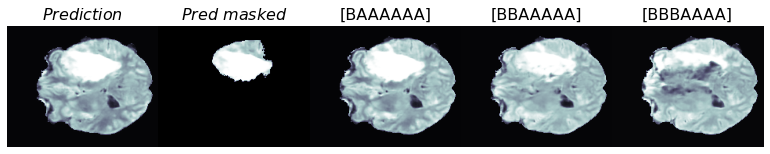

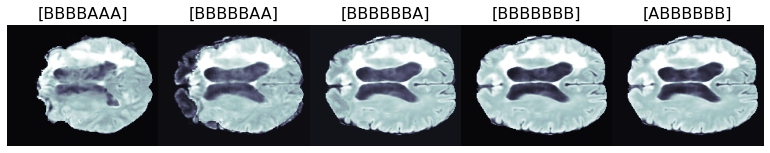

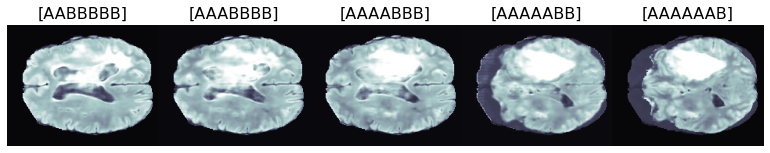

In [0]:
title1 = [r'$Prediction$', r'${Pred\ masked}$', '[BAAAAAA]', '[BBAAAAA]', '[BBBAAAA]']
title2 = ['[BBBBAAA]', '[BBBBBAA]', '[BBBBBBA]','[BBBBBBB]', '[ABBBBBB]']
title3 = ['[AABBBBB]','[AAABBBB]','[AAAABBB]', '[AAAAABB]', '[AAAAAAB]']


idx = 0
model = 1
indexes = [2,10,11,13,18,22,23,26,29,25,37,38,41,42,45,46]
for t1_A, t2_A, t1c_A, tflair_A, segmentation_A, patient_A in testing.take(112):
    if idx == 2:
        print(idx)
        print(patient_A[0].numpy())
        print(patient_B[0].numpy())
        # preparing the input to the generator
        insert_B_from_right = True

        if model == 0:      # pix2pix
            inp_A = t2_A
            inp_B = t2_B
        elif model == 1:    # MI-pix2pix
            inp_A = tf.concat([t1_A, t2_A, t1c_A], 3)
            inp_B = tf.concat([t1_B, t2_B, t1c_B], 3)
        elif model == 2:    # MI-GAN
            inp_A = tf.concat([t1_A, t1c_A, t2_A], 3)
            inp_B = tf.concat([t1_B, t1c_B, t2_B], 3)
        

        (prediction1, prediction2, prediction3, prediction4, prediction5, 
        prediction6, prediction7, prediction8, prediction9, prediction10, 
        prediction11, prediction12, prediction13, prediction14) = generate_predictions(generators, inp_A, inp_B, True)


        # crop the images
        t2_B_cr, t2_A_cr, tflair_A_cr, tflair_B_cr = resize_with_crop(t2_B, t2_A, tflair_A, tflair_B)
        t2_A_cr, prediction1_cr, prediction2_cr, segmentation_cr = resize_with_crop(t2_A, prediction1, prediction2, segmentation_A)
        prediction3_cr, prediction4_cr, prediction5_cr, prediction6_cr = resize_with_crop(prediction3, prediction4, prediction5, prediction6)
        prediction7_cr, prediction8_cr, prediction9_cr, prediction10_cr = resize_with_crop(prediction7, prediction8, prediction9, prediction10)
        prediction11_cr, prediction12_cr, prediction13_cr, prediction14_cr = resize_with_crop(prediction11, prediction12, prediction13, prediction14)
        
        pred1_masked, pred2_masked = retrieve_tumor_area(segmentation_cr,prediction1_cr, prediction2_cr)

        plot_results(prediction1_cr, pred1_masked, prediction2_cr, prediction3_cr, prediction4_cr, title=title1)
        plot_results(prediction5_cr, prediction6_cr, prediction7_cr, prediction8_cr, prediction14_cr, title=title2)
        plot_results(prediction13_cr, prediction12_cr, prediction11_cr, prediction10_cr, prediction9_cr, title=title3)

        print()
        print()
            
    idx += 1

## A&B activation (pix2pix)

1st row: Image B in the skip connections from left (inner one) to right (outer one)

2nd row: Image B in the skip connections from right (outer one) to left (inner one)

b'pat444'
b'pat121'


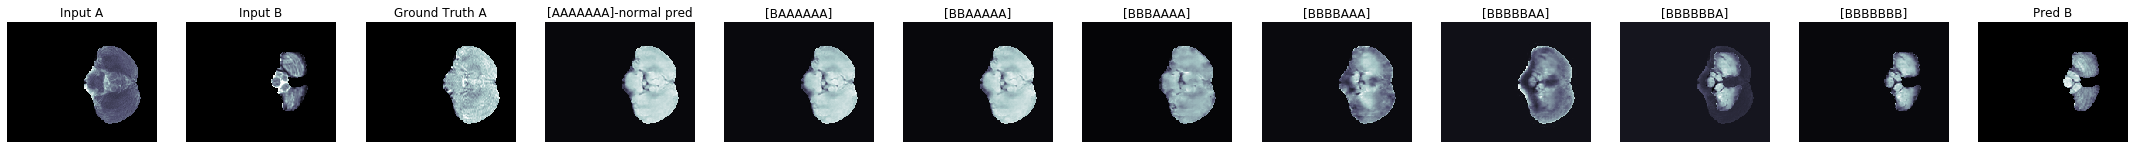

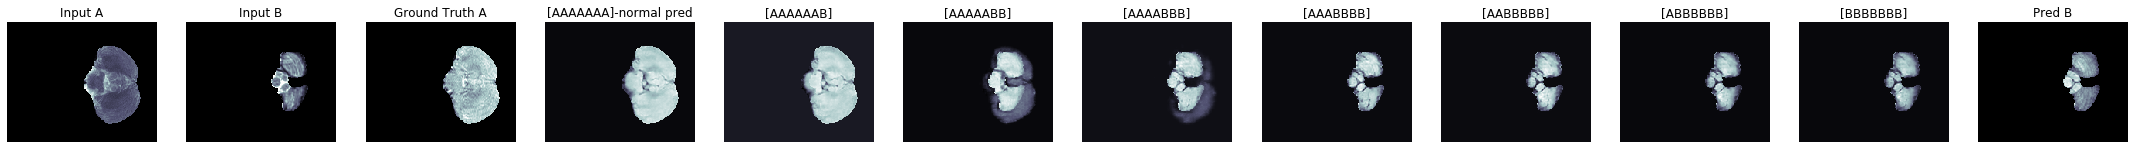

b'pat218'
b'pat444'


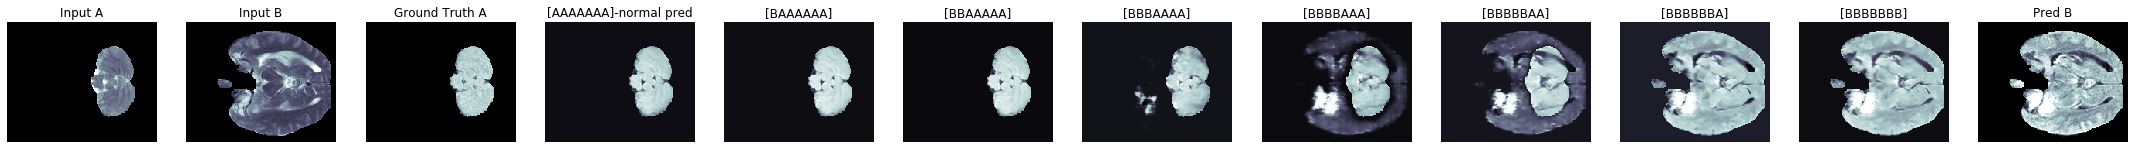

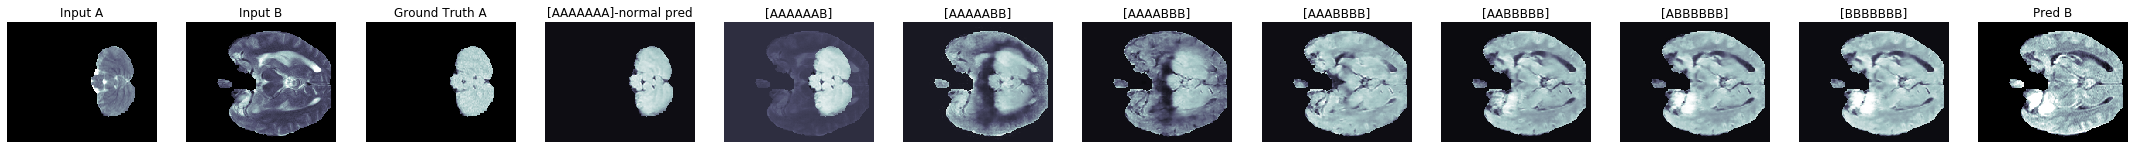

b'pat399'
b'pat218'


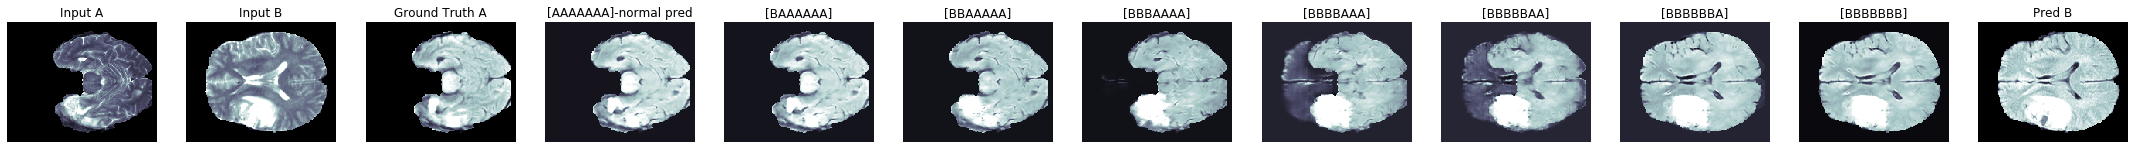

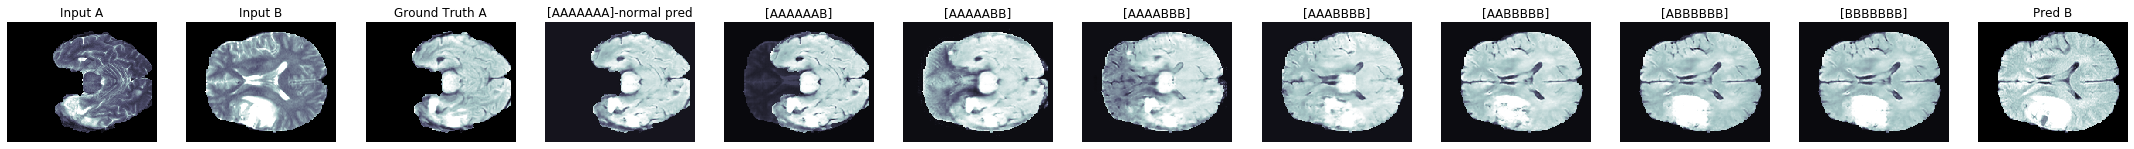

b'pat439'
b'pat399'


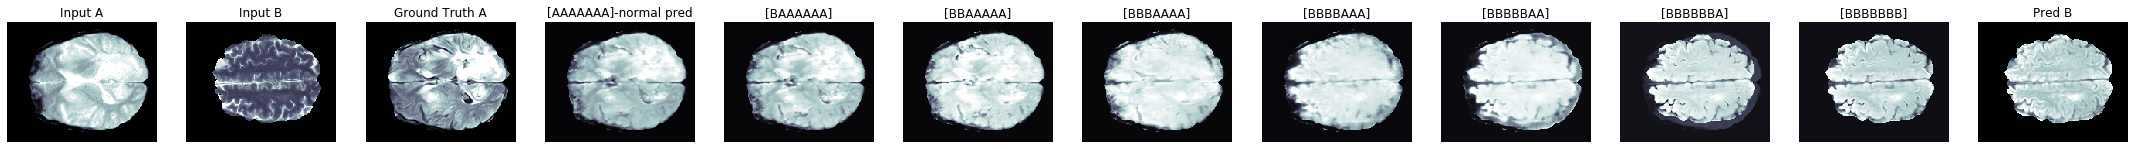

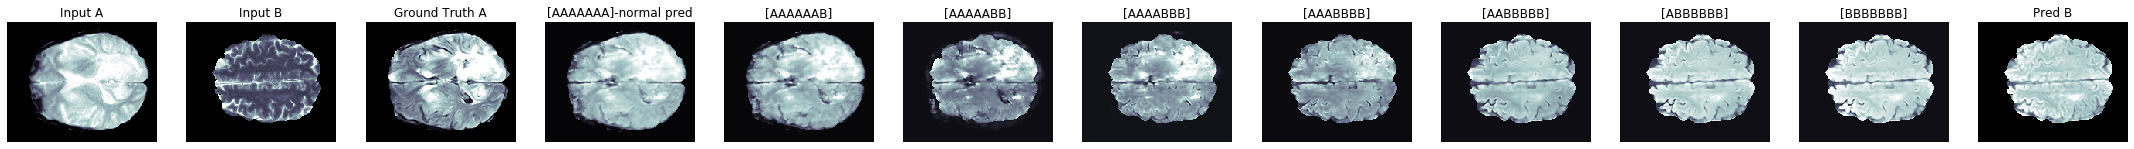

b'pat396'
b'pat186'


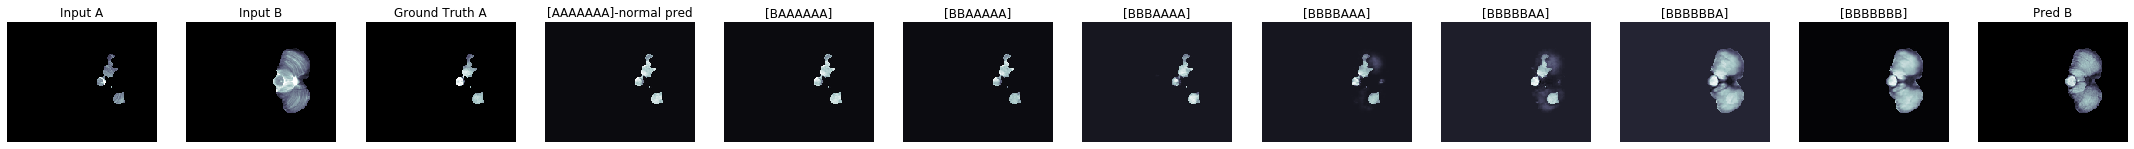

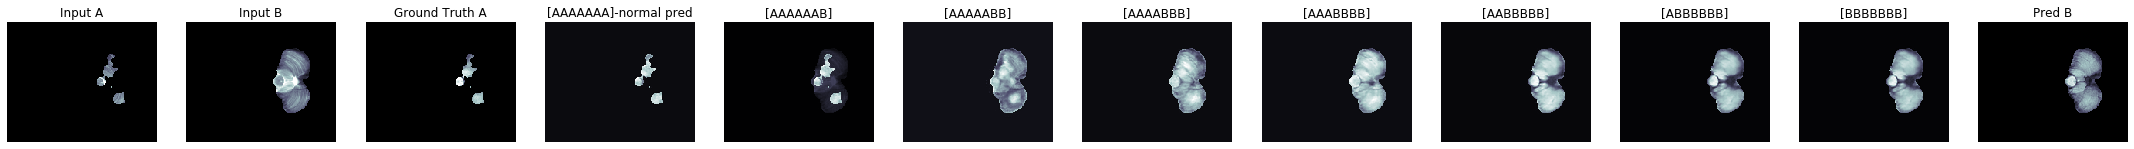

b'pat149'
b'pat396'


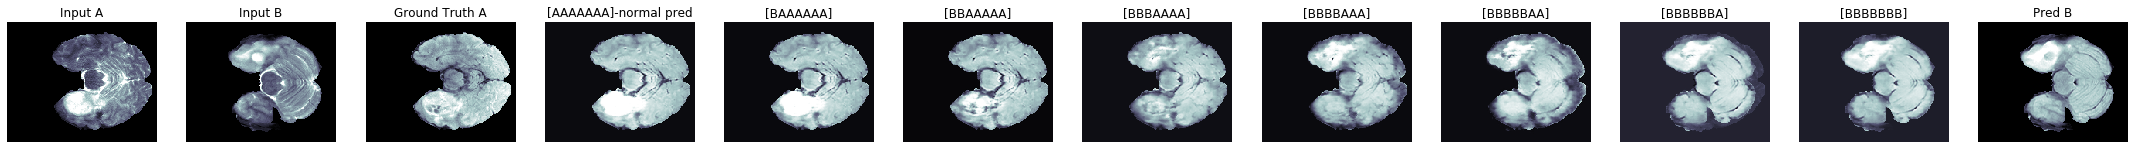

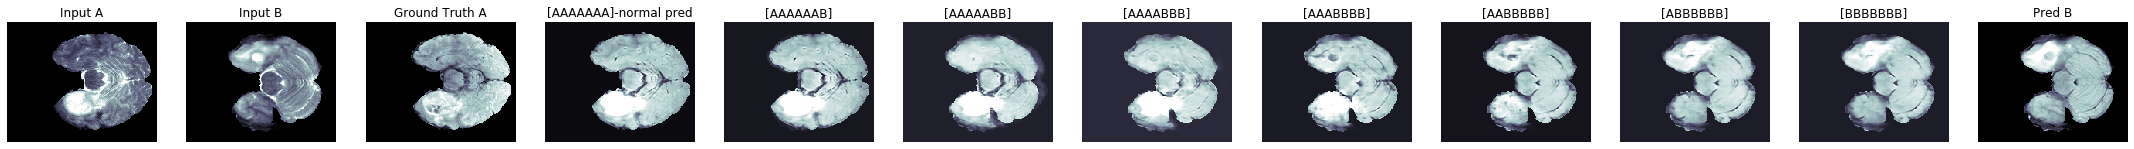

b'pat0002'
b'pat149'


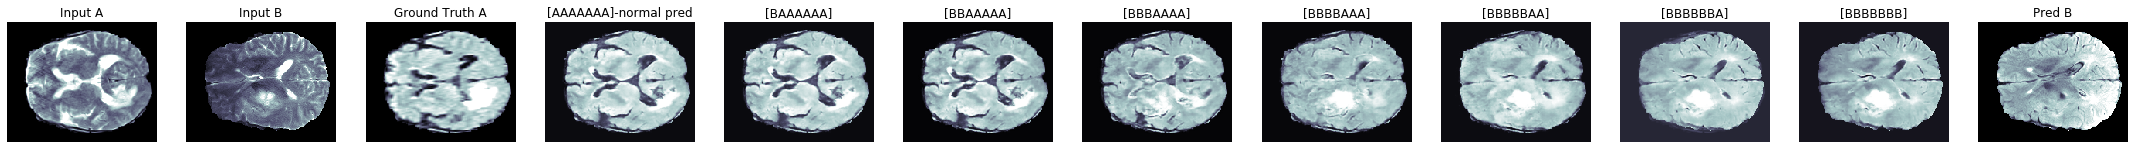

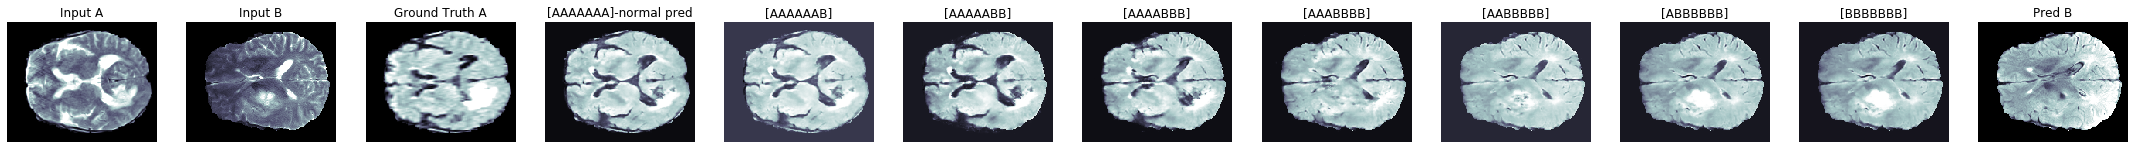

b'pat419'
b'pat0002'


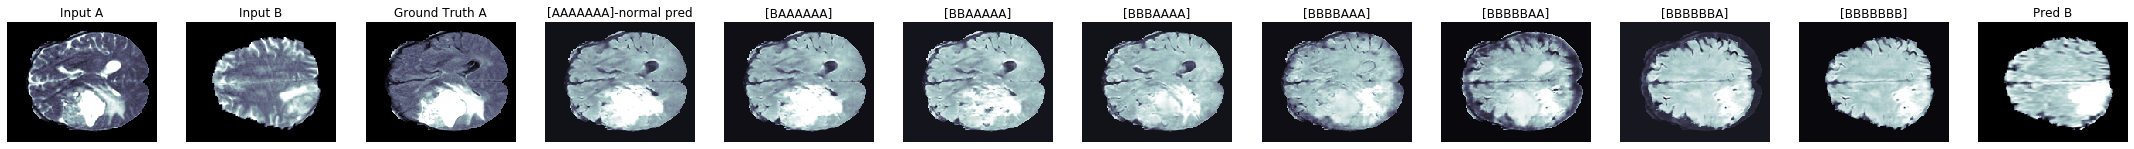

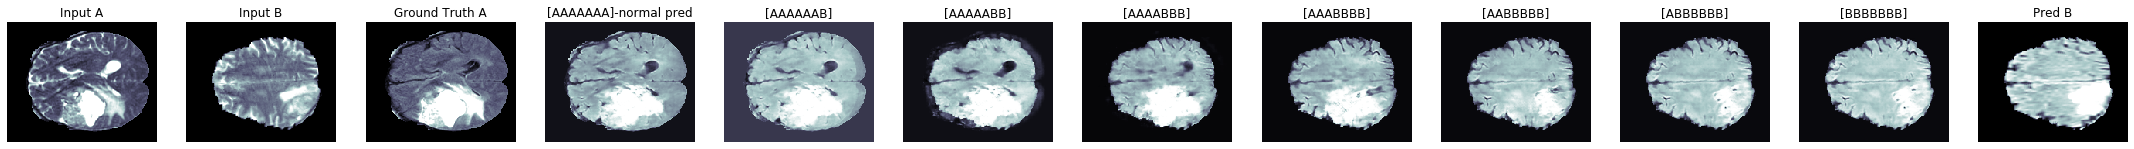

b'pat230'
b'pat314'


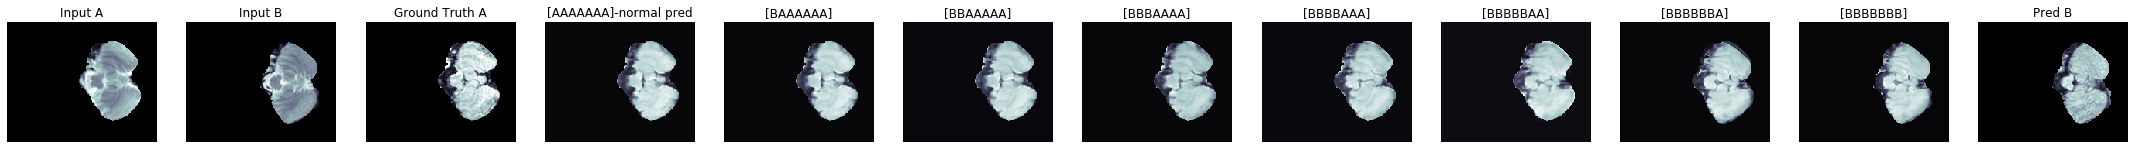

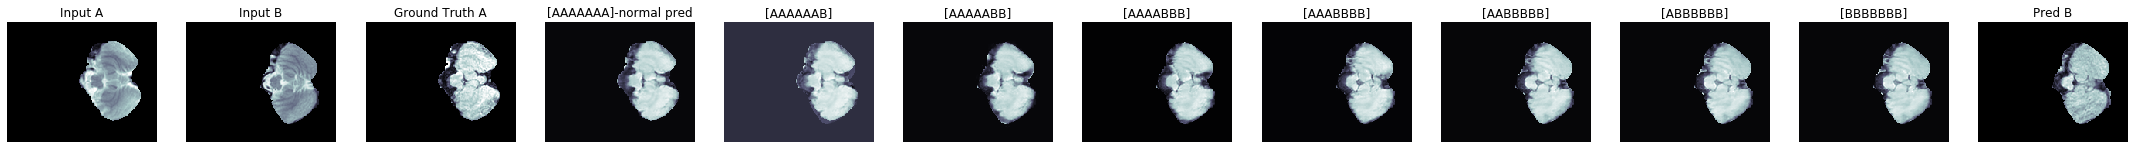

In [0]:
model = 0
print_qualitative_results(testing, model, focus_on_tumor = False)

## A&B activation (MI-pix2pix)

1st row: Image B in the skip connections from left (inner one) to right (outer one)

2nd row: Image B in the skip connections from right (outer one) to left (inner one)

In [0]:
model = 1
print_qualitative_results(testing, model, focus_on_tumor = False)

## A&B activation (MI-GAN)

1st row: Image B in the skip connections from left (inner one) to right (outer one)

2nd row: Image B in the skip connections from right (outer one) to left (inner one)

In [0]:
model = 2
print_qualitative_results(testing, model, focus_on_tumor = False)

# Print qualitative results (images) - TUMOR AREA

## A&B activation (pix2pix)

1st row: Image B in the skip connections from left (inner one) to right (outer one)

2nd row: Image B in the skip connections from right (outer one) to left (inner one)

In [0]:
# pix2pix = 0
# MI-pix2pix = 1
# MI-GAN = 2

model = 0
print_qualitative_results(testing, model, focus_on_tumor = True)

## A&B activation (MI-pix2pix)

1st row: Image B in the skip connections from left (inner one) to right (outer one)

2nd row: Image B in the skip connections from right (outer one) to left (inner one)

In [0]:
model = 1
print_qualitative_results(testing, model, focus_on_tumor = True)

## A&B activation (MI-GAN)

1st row: Image B in the skip connections from left (inner one) to right (outer one)

2nd row: Image B in the skip connections from right (outer one) to left (inner one)

In [0]:
model = 2
print_qualitative_results(testing, model, focus_on_tumor = True)